In [2]:
%matplotlib inline

from pathlib import Path

import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import pairwise
from sklearn.cluster import KMeans
import matplotlib.pylab as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates

DATA = Path('.').resolve()

In [3]:
bathsoap_df = pd.read_csv(DATA / 'BathSoap.csv', skiprows=1, header=1)
#skip columns after 'PropCat 15'
bathsoap_df = bathsoap_df.loc[:,:'PropCat 15']
#clean the data
bathsoap_df.columns = [s.strip().replace('.', '') for s in bathsoap_df.columns]
bathsoap_df.columns = [s.strip().replace(',', '') for s in bathsoap_df.columns]
bathsoap_df.columns = [s.strip().replace('/', 'over') for s in bathsoap_df.columns]
bathsoap_df.columns = [s.strip().replace('%', 'percent') for s in bathsoap_df.columns]
bathsoap_df.columns = [s.strip().replace(' ', '_') for s in bathsoap_df.columns]
#set index as 'Member_id'
bathsoap_df.set_index('Member_id', inplace=True)
#drop the columns which are calculated by other 2 columns that is redundant for our analysis
bathsoap_df = bathsoap_df.drop(columns=['Trans_over_Brand_Runs', 'VoloverTran'])
#change % object to float number
bathsoap_df.loc[:,'Pur_Vol_No_Promo_-_percent':] = bathsoap_df.loc[:,'Pur_Vol_No_Promo_-_percent':].apply(lambda x: x.str.rstrip('%').astype('float') / 100.0)

In [4]:
#get max brand values
bathsoap_df['Br_Max'] = bathsoap_df.loc[:,'Br_Cd_57_144':'Br_Cd_5'].apply(max, axis=1)
bathsoap_df.dtypes

SEC                            float64
FEH                            float64
MT                             float64
SEX                            float64
AGE                            float64
EDU                            float64
HS                             float64
CHILD                          float64
CS                             float64
Affluence_Index                float64
No_of_Brands                   float64
Brand_Runs                     float64
Total_Volume                   float64
No_of__Trans                   float64
Value                          float64
Avg_Price                      float64
Pur_Vol_No_Promo_-_percent     float64
Pur_Vol_Promo_6_percent        float64
Pur_Vol_Other_Promo_percent    float64
Br_Cd_57_144                   float64
Br_Cd_55                       float64
Br_Cd_272                      float64
Br_Cd_286                      float64
Br_Cd_24                       float64
Br_Cd_481                      float64
Br_Cd_352                

# 1. Use k-means clustering to identify clusters of households: 
a) The variables that describe purchase behavior (including brand loyalty) 
b) The variables that describe the basis for purchase 
c) The variables that describe both purchase behavior and basis of purchase

a) The variables for purchasing behavior: No_of_Brands, Brand_Runs, Total_Volume, No_of__Trans, Value, Avg_Price, Others_999, Br_Max

b) The variables for the basis of purchase: Pur_Vol_No_Promo_-_percent, Pur_Vol_Promo_6_percent, Pur_Vol_Other_Promo_percent, Pr_Cat_1, Pr_Cat_2 , Pr_Cat_3, Pr_Cat_4, PropCat_5, PropCat_6, PropCat_7, PropCat_8, PropCat_9, PropCat_10, PropCat_11, PropCat_12, PropCat_13, PropCat_14, PropCat_15
c) Brand_Runs, Total_Volume, Avg_Price, Others_999, Br_Max, Pur_Vol_No_Promo_-_percent, Pur_Vol_Promo_6_percent, Pur_Vol_Other_Promo_percent, Pr_Cat_1, Pr_Cat_2 , Pr_Cat_3, Pr_Cat_4, PropCat_5, PropCat_6, PropCat_7, PropCat_8, PropCat_9, PropCat_10, PropCat_11, PropCat_12, PropCat_13, PropCat_14, PropCat_15

In [5]:
behaviorColumns = ['No_of_Brands', 'Brand_Runs', 'Total_Volume', 'No_of__Trans', 'Value', 'Avg_Price', 'Others_999', 'Br_Max']
purchasebehavior_df = bathsoap_df[behaviorColumns]
purchasebehavior_df = purchasebehavior_df.dropna()
purchasebehavior_df_norm = purchasebehavior_df.apply(preprocessing.scale, axis=0)

   No_of_Brands  Brand_Runs  Total_Volume  No_of__Trans     Value  Avg_Price  \
0     -0.553306   -0.664721     -0.427511     -0.622916 -0.535128  -0.188447   
1      0.553306    0.664721      0.427511      0.622916  0.535128   0.188447   

   Others_999  Br_Max  
0   -0.366136   0.481  
1    0.366136  -0.481  
Cluster 0 (300 members): 1580.81 within cluster
Cluster 1 (300 members): 2015.54 within cluster


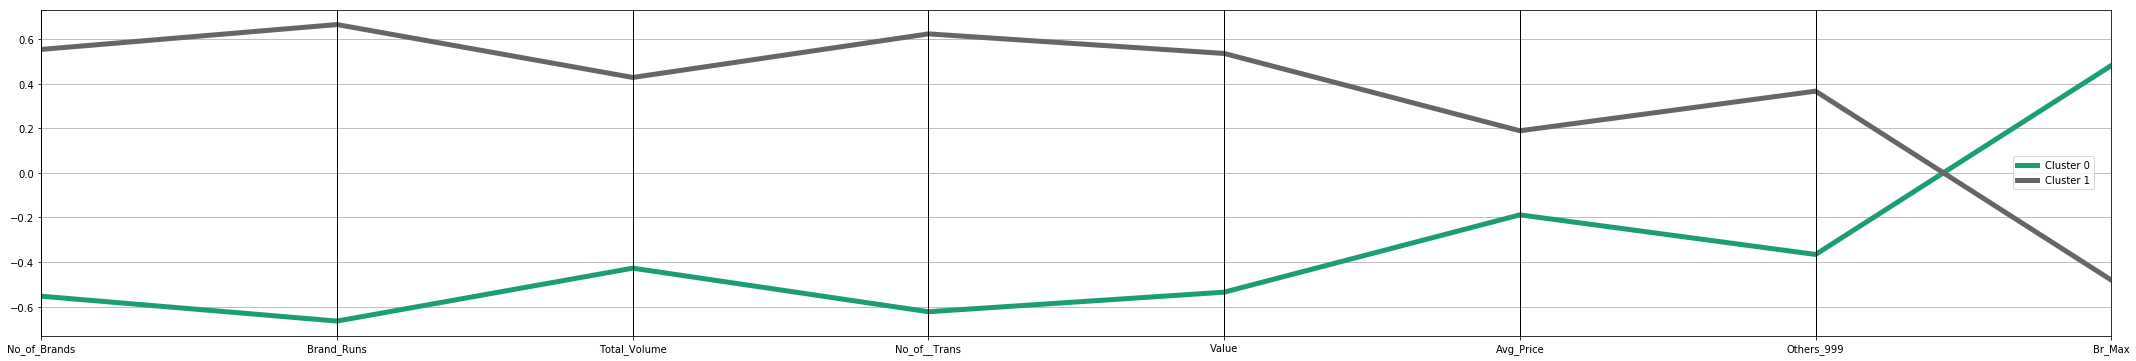

In [6]:
def myKmeans(numclusters, df):
    kmeans = KMeans(n_clusters=numclusters, random_state=0).fit(df)
    memb = pd.Series(kmeans.labels_, index=df.index)
    centroids = pd.DataFrame(kmeans.cluster_centers_, columns=df.columns)
    print(centroids)
    withinClusterSS = [0] * numclusters
    clusterCount = [0] * numclusters
    for cluster, distance in zip(kmeans.labels_, kmeans.transform(df)):
        withinClusterSS[cluster] += distance[cluster]**2
        clusterCount[cluster] += 1
    for cluster, withClustSS in enumerate(withinClusterSS):
        print('Cluster {} ({} members): {:5.2f} within cluster'.format(cluster, 
            clusterCount[cluster], withinClusterSS[cluster]))
    centroids['cluster'] = ['Cluster {}'.format(i) for i in centroids.index]
    fig = plt.figure(figsize=(10, 6))
    fig.subplots_adjust(right=3)
    ax = parallel_coordinates(centroids, class_column='cluster', colormap='Dark2', linewidth=5)
    plt.legend(loc='center left', bbox_to_anchor=(0.95, 0.5))
    centroids
myKmeans(2, purchasebehavior_df_norm)

We can see cluster 0 customers prefer Others_999 brands that is not brand loyal. cluster 1 customers has brand loyalty.

   No_of_Brands  Brand_Runs  Total_Volume  No_of__Trans     Value  Avg_Price  \
0      0.842862    0.977052      0.770300      0.982953  0.883968   0.106363   
1     -0.316724   -0.201539     -0.479162     -0.387250 -0.413151   0.227738   
2     -0.430910   -0.710127     -0.152558     -0.479788 -0.348940  -0.394831   

   Others_999    Br_Max  
0    0.192046 -0.394797  
1    0.743302 -0.666878  
2   -1.135246  1.238600  
Cluster 0 (182 members): 1255.23 within cluster
Cluster 1 (234 members): 915.77 within cluster
Cluster 2 (184 members): 711.45 within cluster


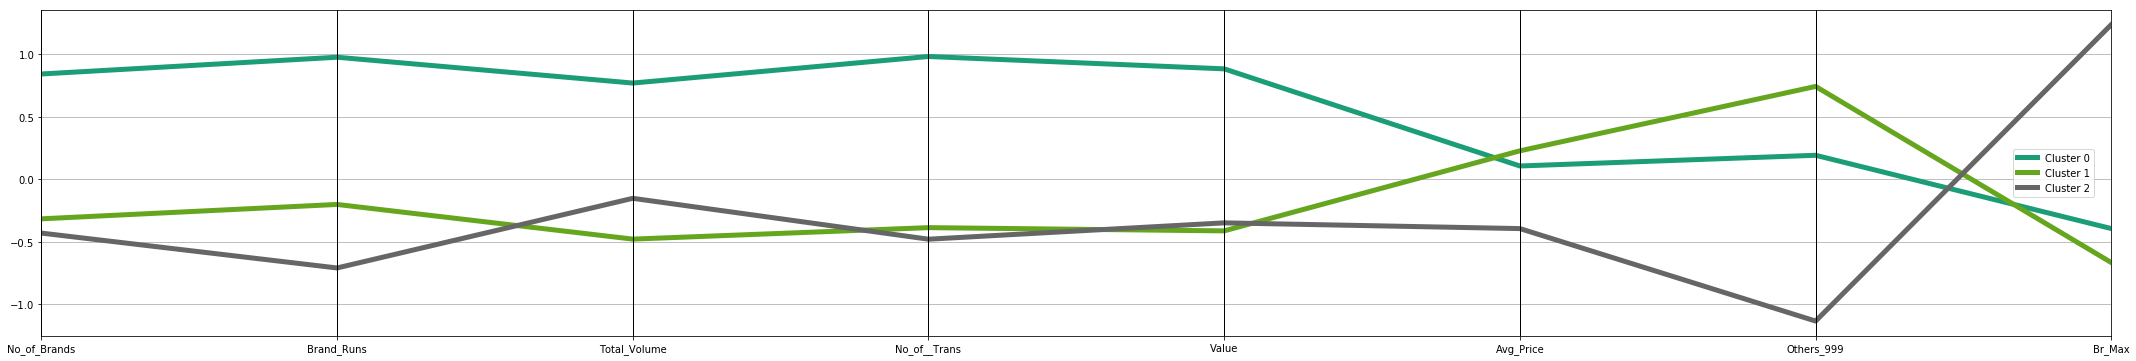

In [7]:
myKmeans(3, purchasebehavior_df_norm)

We can see cluster 0 has largest number of brands, number of transaction and total values, but since brand loyalty is between cluster 0 and 2, the average price is between. Cluster 2 has highest brand loyalty and lowest brand runs.

   No_of_Brands  Brand_Runs  Total_Volume  No_of__Trans     Value  Avg_Price  \
0     -0.590953   -0.385899     -0.541569     -0.527594 -0.469663   0.252911   
1      0.023598    0.082503      2.330801      0.627910  2.201423  -0.229197   
2     -0.420674   -0.699409     -0.215336     -0.506840 -0.393034  -0.381813   
3      0.946242    1.006628      0.151721      0.824517  0.285050   0.183041   

   Others_999    Br_Max  
0    0.879657 -0.722945  
1   -0.018379  0.047625  
2   -1.122797  1.206645  
3    0.254473 -0.487498  
Cluster 0 (179 members): 665.13 within cluster
Cluster 1 (46 members): 369.12 within cluster
Cluster 2 (183 members): 669.36 within cluster
Cluster 3 (192 members): 817.05 within cluster


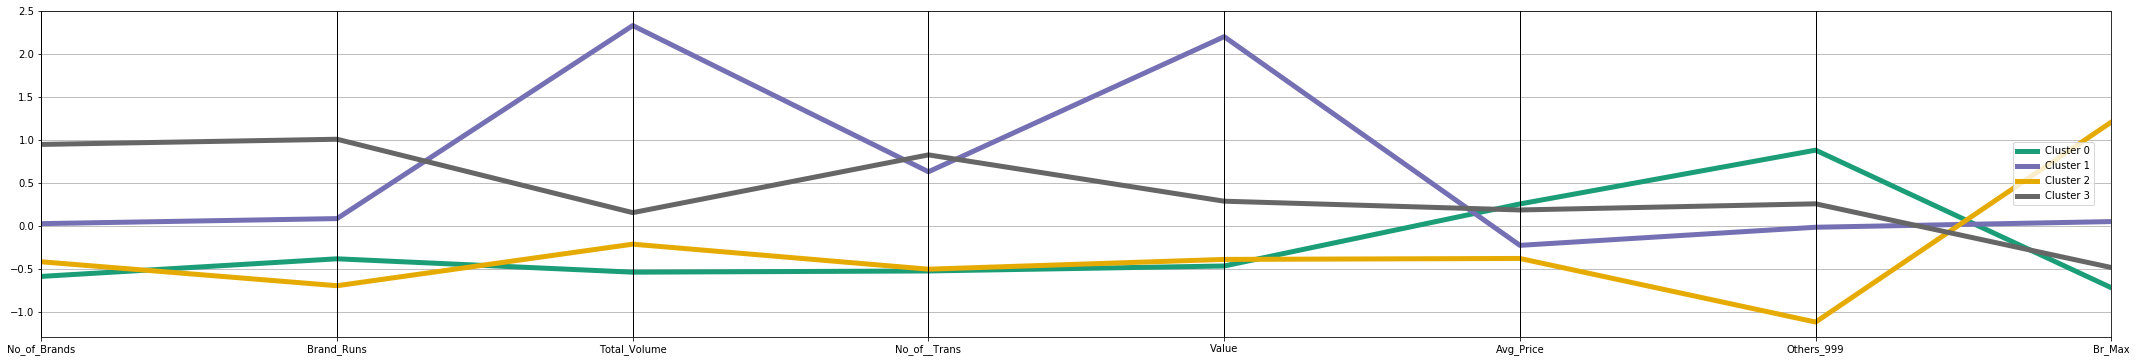

In [8]:
myKmeans(4, purchasebehavior_df_norm)

   No_of_Brands  Brand_Runs  Total_Volume  No_of__Trans     Value  Avg_Price  \
0     -0.769921   -0.553006     -0.621768     -0.653244 -0.584904   0.202389   
1      0.588003    0.470324     -0.139665      0.238765 -0.012835   0.223375   
2     -0.532496   -0.789148     -0.228400     -0.560419 -0.443398  -0.444017   
3      1.329016    1.798823      0.770211      1.784064  0.935352   0.137540   
4     -0.155451   -0.099566      2.186264      0.416920  2.045971  -0.229081   

   Others_999    Br_Max  
0    0.954621 -0.748263  
1    0.215028 -0.401373  
2   -1.202402  1.329553  
3    0.284401 -0.526695  
4   -0.099388  0.156312  
Cluster 0 (140 members): 512.39 within cluster
Cluster 1 (193 members): 549.47 within cluster
Cluster 2 (157 members): 548.04 within cluster
Cluster 3 (64 members): 371.15 within cluster
Cluster 4 (46 members): 311.78 within cluster


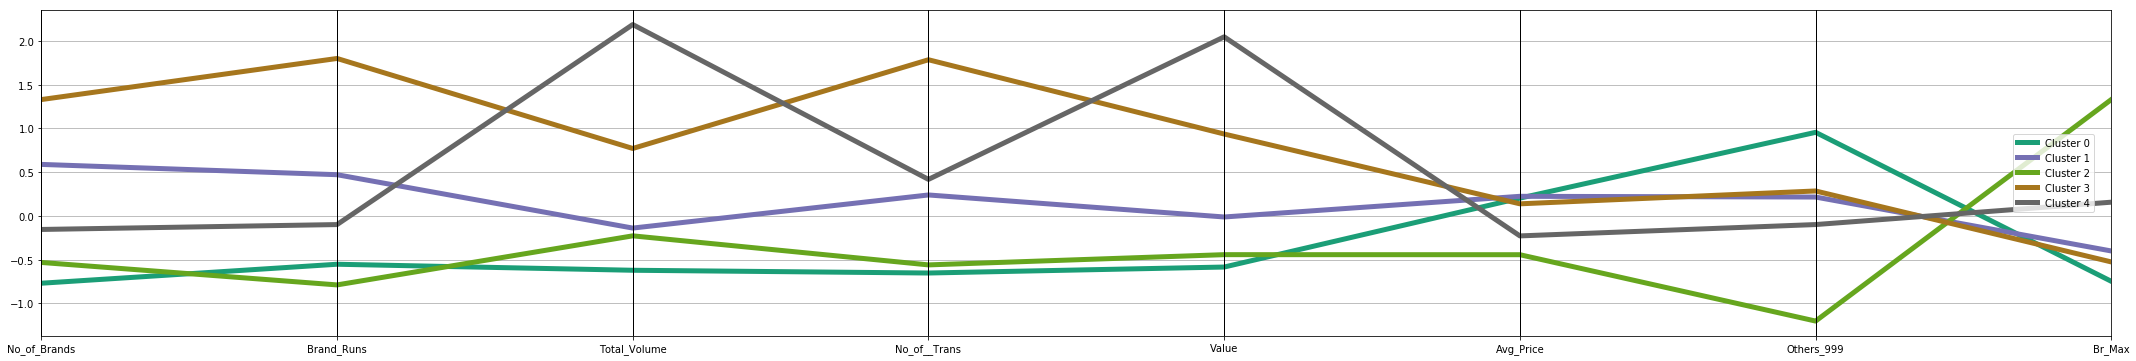

In [9]:
myKmeans(5, purchasebehavior_df_norm)

We can swee cluster 2 is the most brand loyalty and least brand runs.Cluster 1 has the max total volumn and total values. Cluster 0 is has the most Others_999 shares, least brand loyalty and number of brands.

In [10]:
basisColumns = ['Pur_Vol_No_Promo_-_percent', 'Pur_Vol_Promo_6_percent', 'Pur_Vol_Other_Promo_percent', 
                   'Pr_Cat_1', 'Pr_Cat_2', 'Pr_Cat_3', 'Pr_Cat_4', 'PropCat_5', 'PropCat_6', 'PropCat_7', 'PropCat_8', 
                   'PropCat_9', 'PropCat_10', 'PropCat_11', 'PropCat_12', 'PropCat_13', 'PropCat_14', 'PropCat_15']
purchasebasis_df = bathsoap_df[basisColumns]
purchasebasis_df = purchasebasis_df.dropna()
purchasebasis_df_norm = purchasebasis_df.apply(preprocessing.scale, axis=0)

   Pur_Vol_No_Promo_-_percent  Pur_Vol_Promo_6_percent  \
0                    0.206235                -0.405305   
1                   -0.030817                 0.060563   

   Pur_Vol_Other_Promo_percent  Pr_Cat_1  Pr_Cat_2  Pr_Cat_3  Pr_Cat_4  \
0                     0.180995 -0.784981 -1.124907  2.370682 -0.336462   
1                    -0.027045  0.117296  0.168090 -0.354240  0.050276   

   PropCat_5  PropCat_6  PropCat_7  PropCat_8  PropCat_9  PropCat_10  \
0  -1.099435  -0.171165  -0.443109  -0.464819  -0.167063   -0.256817   
1   0.164283   0.025576   0.066212   0.069456   0.024963    0.038375   

   PropCat_11  PropCat_12  PropCat_13  PropCat_14  PropCat_15  
0   -0.229325   -0.160097   -0.232447    2.375214   -0.215082  
1    0.034267    0.023923    0.034733   -0.354917    0.032139  
Cluster 0 (78 members): 402.36 within cluster
Cluster 1 (522 members): 9015.25 within cluster


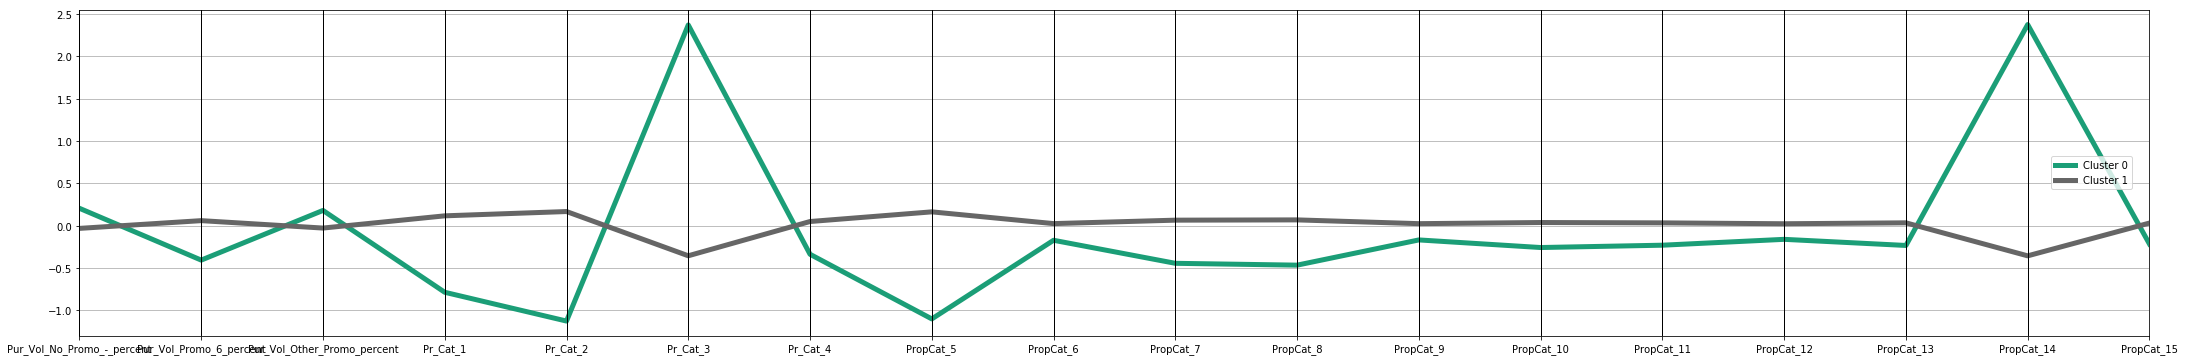

In [11]:
myKmeans(2, purchasebasis_df_norm)

We can see cluster 0 buys more under other promotion, but cluster buys more under promotion 6, under price category 3, cluster 0 has peak, the same under product proposition category 14.

   Pur_Vol_No_Promo_-_percent  Pur_Vol_Promo_6_percent  \
0                   -0.073176                 0.114940   
1                    0.206235                -0.405305   
2                    0.106594                -0.115832   

   Pur_Vol_Other_Promo_percent  Pr_Cat_1  Pr_Cat_2  Pr_Cat_3  Pr_Cat_4  \
0                    -0.026884 -0.351360  0.476475 -0.319469  0.187124   
1                     0.180995 -0.784981 -1.124907  2.370682 -0.336462   
2                    -0.027568  1.637571 -0.832282 -0.467034 -0.393647   

   PropCat_5  PropCat_6  PropCat_7  PropCat_8  PropCat_9  PropCat_10  \
0   0.345670  -0.068942  -0.043295   0.045985   0.077171   -0.146407   
1  -1.099435  -0.171165  -0.443109  -0.464819  -0.167063   -0.256817   
2  -0.424116   0.332185   0.421440   0.145593  -0.144393    0.637790   

   PropCat_11  PropCat_12  PropCat_13  PropCat_14  PropCat_15  
0    0.098366   -0.096450   -0.186116   -0.322317    0.072125  
1   -0.229325   -0.160097   -0.232447    2.375214   -

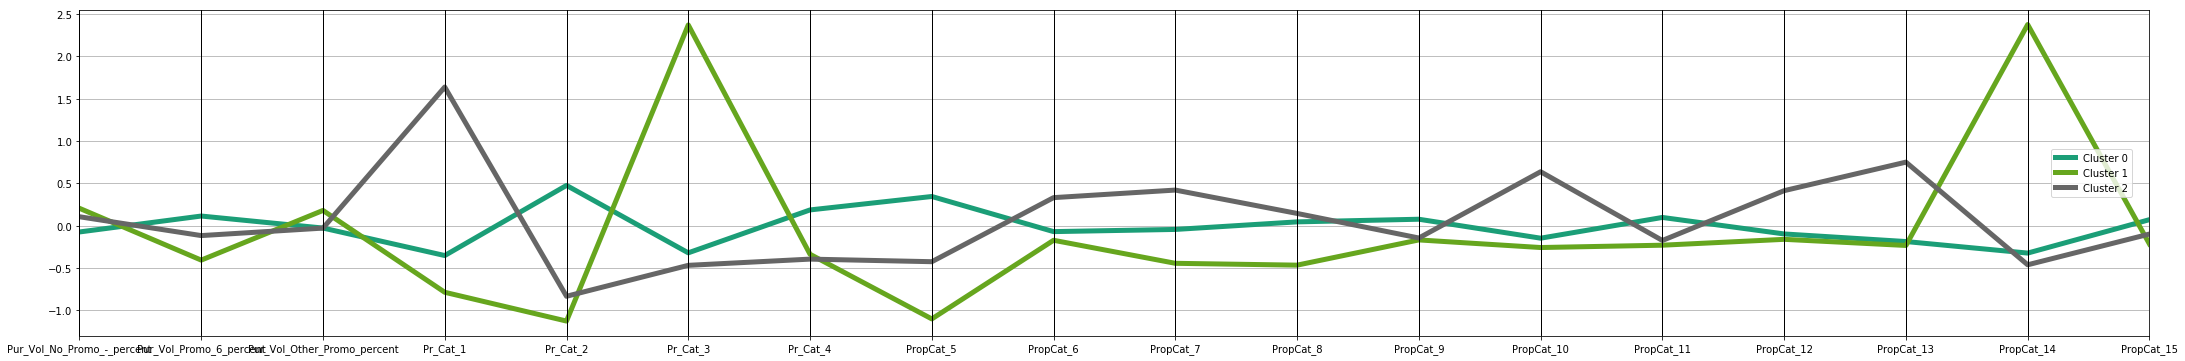

In [12]:
myKmeans(3, purchasebasis_df_norm)

   Pur_Vol_No_Promo_-_percent  Pur_Vol_Promo_6_percent  \
0                    0.211742                -0.419444   
1                    0.217378                -0.263964   
2                    0.308649                -0.278351   
3                   -1.699589                 1.843746   

   Pur_Vol_Other_Promo_percent  Pr_Cat_1  Pr_Cat_2  Pr_Cat_3  Pr_Cat_4  \
0                     0.190296 -0.782309 -1.136548  2.384314 -0.340587   
1                    -0.020096  1.608364 -0.819962 -0.464711 -0.374036   
2                    -0.152849 -0.445485  0.548615 -0.297901  0.177672   
3                     0.440211  0.093197  0.141223 -0.389539  0.178389   

   PropCat_5  PropCat_6  PropCat_7  PropCat_8  PropCat_9  PropCat_10  \
0  -1.100846  -0.166018  -0.448869  -0.461215  -0.162855   -0.256719   
1  -0.436241   0.342431   0.437863   0.216763  -0.181065    0.505399   
2   0.480182  -0.012620  -0.020496  -0.172116   0.046100   -0.165580   
3  -0.188287  -0.296688  -0.143136   0.773378   0.

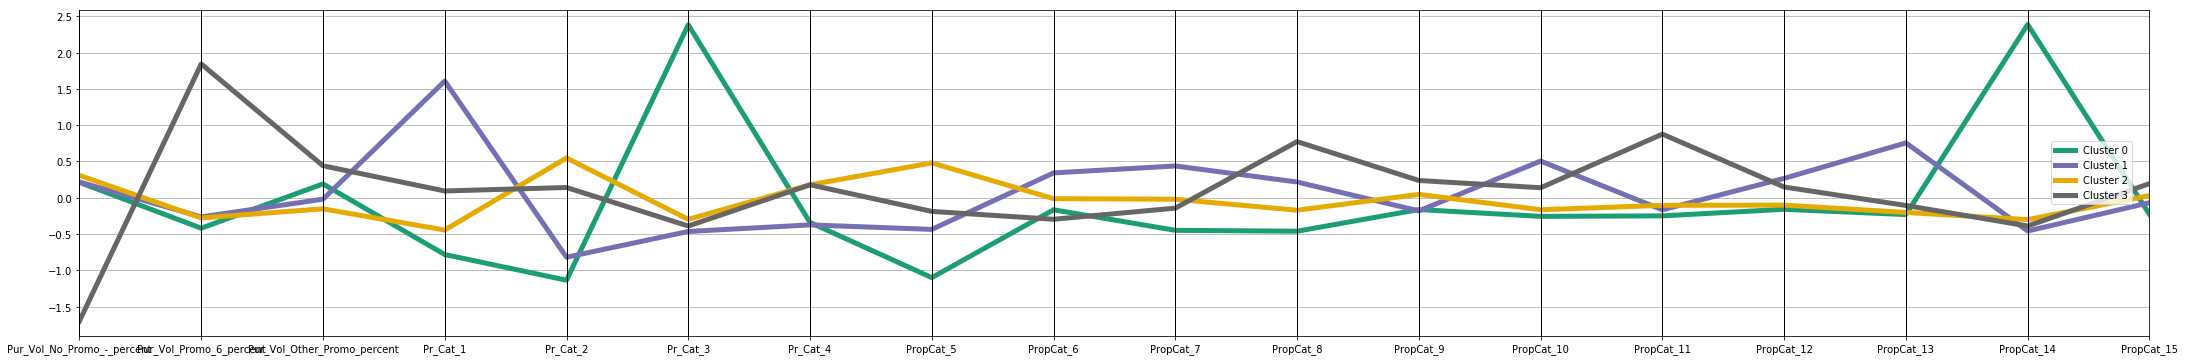

In [13]:
myKmeans(4, purchasebasis_df_norm)

   Pur_Vol_No_Promo_-_percent  Pur_Vol_Promo_6_percent  \
0                    0.303904                -0.246443   
1                   -1.215691                 1.222650   
2                    0.148651                -0.114140   
3                    0.004940                -0.014512   
4                    0.225990                -0.438912   

   Pur_Vol_Other_Promo_percent  Pr_Cat_1  Pr_Cat_2  Pr_Cat_3  Pr_Cat_4  \
0                    -0.186021 -0.463457  0.797516 -0.277081 -0.229735   
1                     0.439179 -0.309684 -0.539908 -0.321130  1.780409   
2                    -0.099401  1.739644 -0.923370 -0.469209 -0.392192   
3                     0.010138  0.492585  0.123806 -0.432012 -0.318810   
4                     0.191610 -0.783833 -1.140465  2.400908 -0.355125   

   PropCat_5  PropCat_6  PropCat_7  PropCat_8  PropCat_9  PropCat_10  \
0   0.552418   0.047129  -0.311720  -0.249749  -0.079604   -0.115429   
1   0.576360  -0.297822  -0.294462   0.401906  -0.002729   -0.

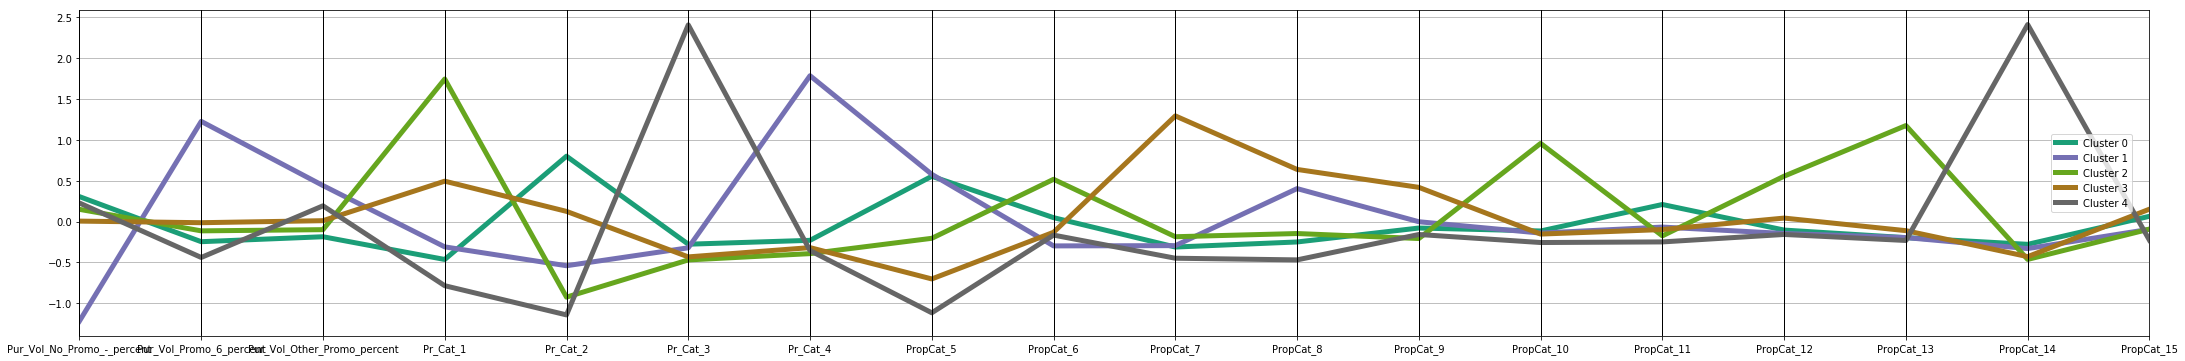

In [14]:
myKmeans(5, purchasebasis_df_norm)

under price category 1, cluster 2 buys the most. cluster 1 on peak at price category 3.

   No_of_Brands  Brand_Runs  Total_Volume  No_of__Trans     Value  Avg_Price  \
0      0.067896    0.100262     -0.021480      0.049931  0.068907   0.180901   
1     -0.490153   -0.723809      0.155068     -0.360462 -0.497454  -1.305956   

   Pur_Vol_No_Promo_-_percent  Pur_Vol_Promo_6_percent  \
0                   -0.027378                 0.057242   
1                    0.197646                -0.413241   

   Pur_Vol_Other_Promo_percent  Pr_Cat_1    ...     PropCat_8  PropCat_9  \
0                    -0.028490  0.110123    ...      0.065688   0.020551   
1                     0.205672 -0.795001    ...     -0.474212  -0.148365   

   PropCat_10  PropCat_11  PropCat_12  PropCat_13  PropCat_14  PropCat_15  \
0    0.035503    0.031110    0.022966    0.032182   -0.341274    0.033460   
1   -0.256301   -0.224586   -0.165793   -0.232326    2.463715   -0.241551   

   Others_999    Br_Max  
0    0.171604 -0.192109  
1   -1.238840  1.386867  

[2 rows x 26 columns]
Cluster 0 (527 members

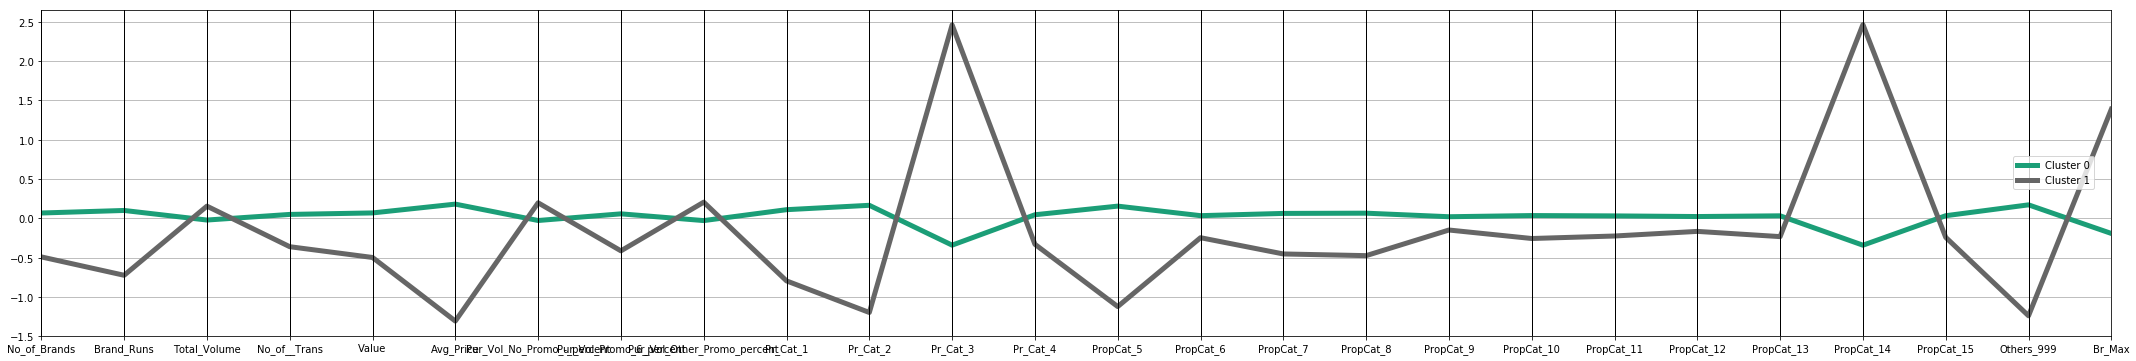

In [15]:
bothColumns = ['No_of_Brands', 'Brand_Runs', 'Total_Volume', 'No_of__Trans', 'Value', 'Avg_Price', 'Pur_Vol_No_Promo_-_percent', 
               'Pur_Vol_Promo_6_percent', 'Pur_Vol_Other_Promo_percent', 'Pr_Cat_1', 'Pr_Cat_2' , 'Pr_Cat_3', 
               'Pr_Cat_4', 'PropCat_5', 'PropCat_6', 'PropCat_7', 'PropCat_8', 'PropCat_9', 'PropCat_10', 'PropCat_11', 
               'PropCat_12', 'PropCat_13', 'PropCat_14', 'PropCat_15', 'Others_999', 'Br_Max']
behaviorbasis_df = bathsoap_df[bothColumns]
behaviorbasis_df = behaviorbasis_df.dropna()
behaviorbasis_df_norm = behaviorbasis_df.apply(preprocessing.scale, axis=0)
myKmeans(2, behaviorbasis_df_norm)

cluster 0 has brand loyalty, peak at price category 3. cluster 1 is a little opposite.

   No_of_Brands  Brand_Runs  Total_Volume  No_of__Trans     Value  Avg_Price  \
0     -0.043389   -0.183942      0.112318     -0.148463  0.012037  -0.283741   
1      0.224406    0.499965     -0.209652      0.328952  0.148889   0.834370   
2     -0.490153   -0.723809      0.155068     -0.360462 -0.497454  -1.305956   

   Pur_Vol_No_Promo_-_percent  Pur_Vol_Promo_6_percent  \
0                    0.224333                -0.206550   
1                   -0.381382                 0.428238   
2                    0.197646                -0.413241   

   Pur_Vol_Other_Promo_percent  Pr_Cat_1    ...     PropCat_8  PropCat_9  \
0                    -0.105697 -0.515522    ...     -0.181828  -0.117486   
1                     0.080095  0.990027    ...      0.413793   0.214687   
2                     0.205672 -0.795001    ...     -0.474212  -0.148365   

   PropCat_10  PropCat_11  PropCat_12  PropCat_13  PropCat_14  PropCat_15  \
0   -0.151284    0.078199   -0.119722   -0.216717   -0.263523   

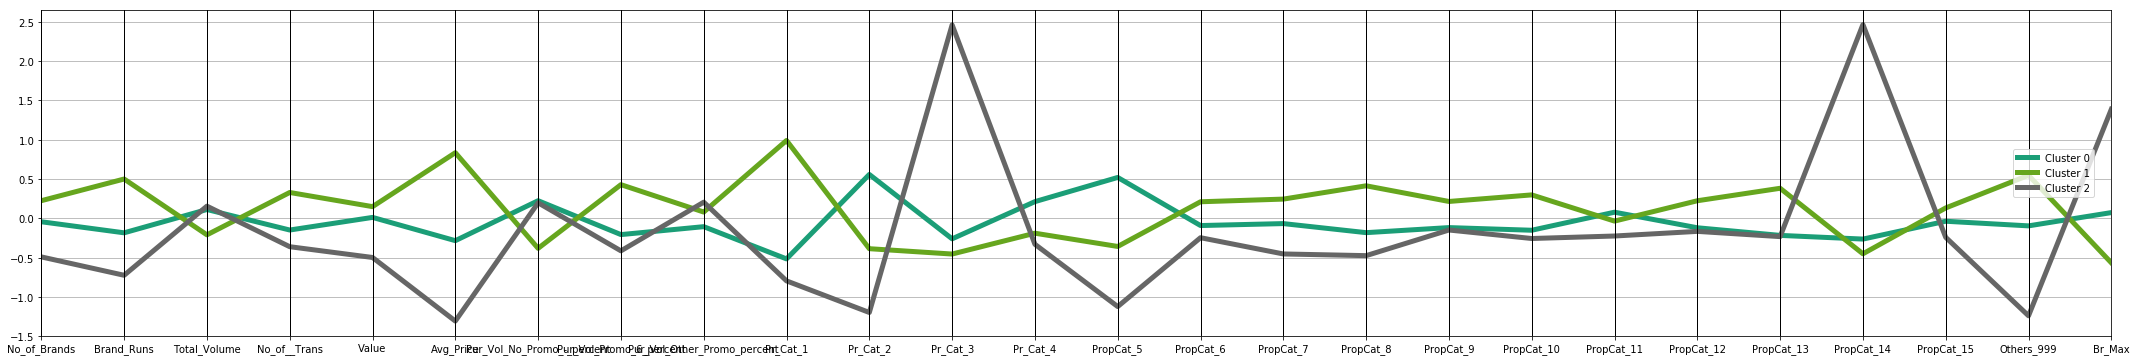

In [16]:
myKmeans(3, behaviorbasis_df_norm)

   No_of_Brands  Brand_Runs  Total_Volume  No_of__Trans     Value  Avg_Price  \
0     -0.322485   -0.419330     -0.022789     -0.376597 -0.123475  -0.307551   
1      0.853584    0.998413      0.370915      0.870445  0.477623   0.074242   
2     -0.397498   -0.296983     -0.646738     -0.406557 -0.197901   1.395797   
3     -0.584380   -0.801237      0.083456     -0.433782 -0.556079  -1.319353   

   Pur_Vol_No_Promo_-_percent  Pur_Vol_Promo_6_percent  \
0                    0.217653                -0.225141   
1                   -0.455864                 0.543176   
2                    0.179336                -0.167849   
3                    0.210426                -0.436258   

   Pur_Vol_Other_Promo_percent  Pr_Cat_1    ...     PropCat_8  PropCat_9  \
0                    -0.070602 -0.572345    ...     -0.150073  -0.173459   
1                     0.055201  0.062250    ...      0.205834   0.412480   
2                    -0.080906  1.654861    ...      0.278629  -0.247616   
3   

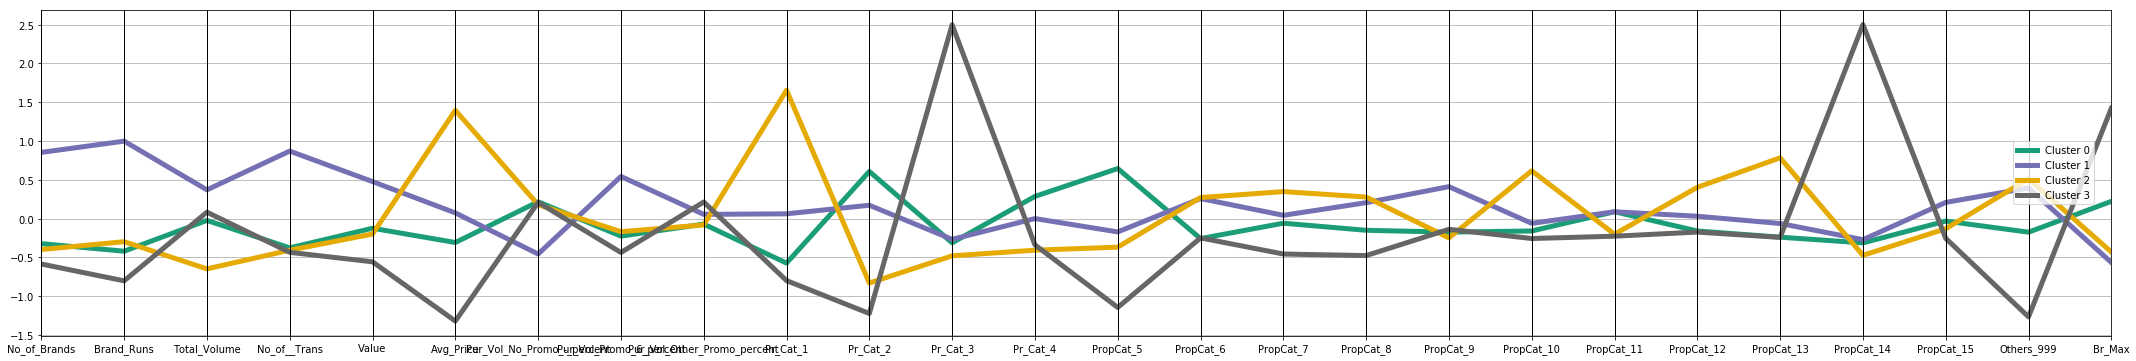

In [17]:
myKmeans(4, behaviorbasis_df_norm)

   No_of_Brands  Brand_Runs  Total_Volume  No_of__Trans     Value  Avg_Price  \
0     -0.391949   -0.293514     -0.647238     -0.403567 -0.205836   1.372204   
1     -0.587003   -0.807614      0.074846     -0.437444 -0.564682  -1.323535   
2     -0.254874   -0.401271     -0.032756     -0.358167 -0.067620  -0.198948   
3      0.955835    1.063250      0.408607      0.927091  0.542048   0.118963   
4     -0.561753   -0.313027      0.047997     -0.280569 -0.329255  -0.772399   

   Pur_Vol_No_Promo_-_percent  Pur_Vol_Promo_6_percent  \
0                    0.165509                -0.148235   
1                    0.239817                -0.476192   
2                    0.279669                -0.307384   
3                   -0.345293                 0.435591   
4                   -0.521874                 0.596561   

   Pur_Vol_Other_Promo_percent  Pr_Cat_1    ...     PropCat_8  PropCat_9  \
0                    -0.083290  1.627755    ...      0.277396  -0.186011   
1                 

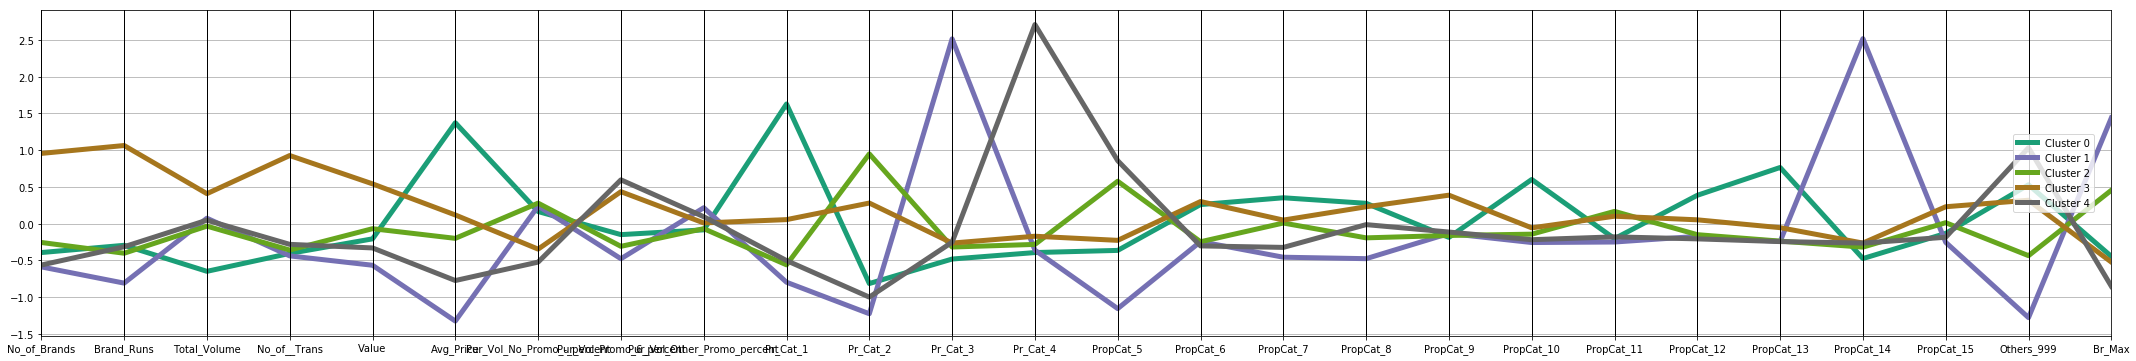

In [18]:
myKmeans(5, behaviorbasis_df_norm)

How k should be chosen: k should be chosen so that the clusters are greatly apart.
The percentages of total purchases comprised by various brands should not be treated as individually, we use Br_Max to give the brand loyalty of the customers.

# 2. Select the best segmentation and comment on (demographic, brand loyalty, and basis for purchase) of these clusters.

We notice from the above analysis, from k=4, the distance within cluster is getting smaller, k=5 is similar as k=4, we know that k=4 is the best segmentation.

,SEC,FEH,MT,SEX,AGE,EDU,HS,CHILD,CS,Affluence_Index,...,PropCat_8,PropCat_9,PropCat_10,PropCat_11,PropCat_12,PropCat_13,PropCat_14,PropCat_15,Br_Max,cluster
Member_id,,,,,,,,,,,,,,,,,,,,,
1010010.0,4.0,3.0,10.0,1.0,4.0,4.0,2.0,4.0,1.0,2.0,...,0.000,0.000,0.0,0.000,0.028,0.0,0.131,0.340,0.377,0
1010020.0,3.0,2.0,10.0,2.0,2.0,4.0,4.0,2.0,1.0,19.0,...,0.016,0.014,0.0,0.059,0.000,0.0,0.081,0.000,0.145,1
1014020.0,2.0,3.0,10.0,2.0,4.0,5.0,6.0,4.0,1.0,23.0,...,0.011,0.009,0.0,0.000,0.016,0.0,0.562,0.003,0.545,1
1014030.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,...,0.000,0.000,0.0,0.000,0.000,0.0,0.600,0.000,0.600,3
1014190.0,4.0,1.0,10.0,2.0,3.0,4.0,4.0,3.0,1.0,10.0,...,0.048,0.000,0.0,0.000,0.000,0.0,0.145,0.000,0.145,0


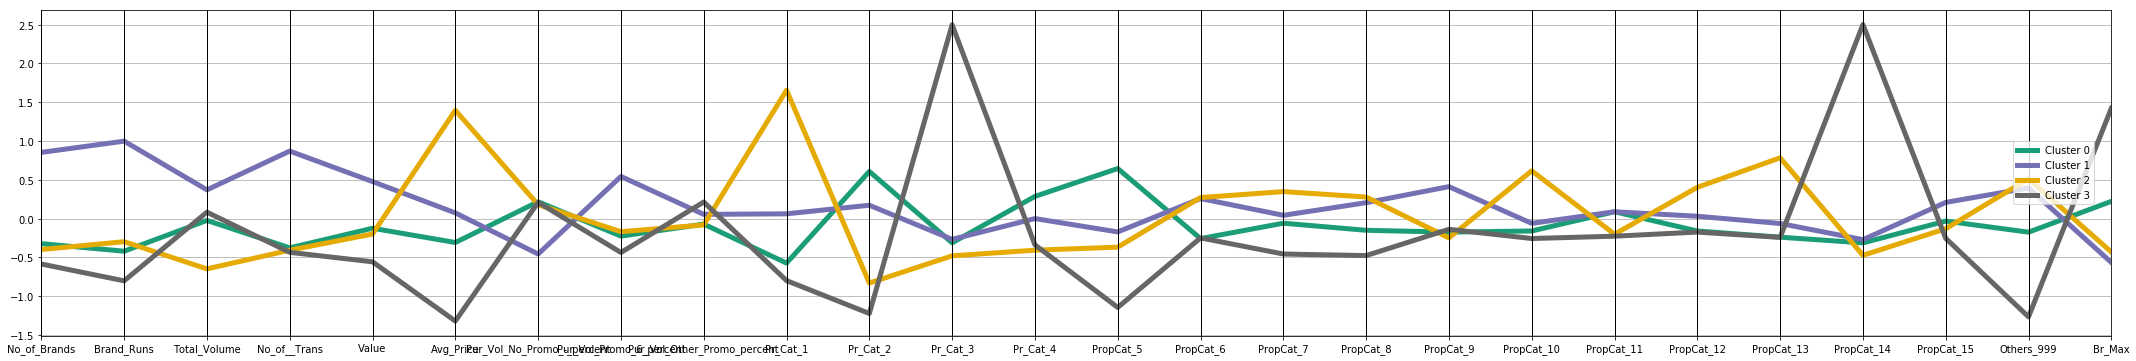

In [29]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(behaviorbasis_df_norm
# Cluster membership
pd.Series(kmeans.labels_, index=behaviorbasis_df_norm.index)
memb = pd.Series(kmeans.labels_, index=behaviorbasis_df_norm.index)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=behaviorbasis_df_norm.columns)
centroids['cluster'] = ['Cluster {}'.format(i) for i in centroids.index]
fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(right=3)
ax = parallel_coordinates(centroids, class_column='cluster', colormap='Dark2', linewidth=5)
plt.legend(loc='center left', bbox_to_anchor=(0.95, 0.5))
bathsoap_df.loc[:,'cluster'] = memb.astype('category')
bathsoap_df.head()

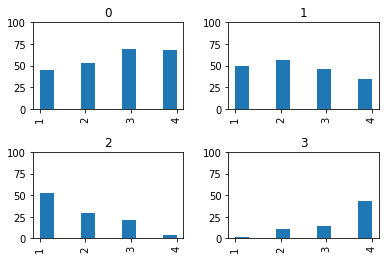

In [27]:
ax = bathsoap_df.hist(by='cluster',column = 'SEC')
ax[0][0].set_ylim((0,100))
ax[0][1].set_ylim((0,100))
ax[1][0].set_ylim((0,100))
ax[1][1].set_ylim((0,100))
plt.show()

From above histogram, in cluster 3, high socio-economic status has high percentage of brand loyalty.some kind of opposite result can be see from cluster 2.

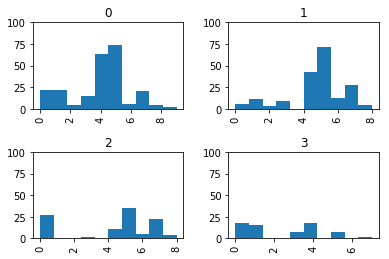

In [30]:
ax = bathsoap_df.hist(by='cluster',column = 'EDU')
ax[0][0].set_ylim((0,100))
ax[0][1].set_ylim((0,100))
ax[1][0].set_ylim((0,100))
ax[1][1].set_ylim((0,100))
plt.show()

cluster 1 seem more advanced education percentage, cluster 0 seems a bit oppositive

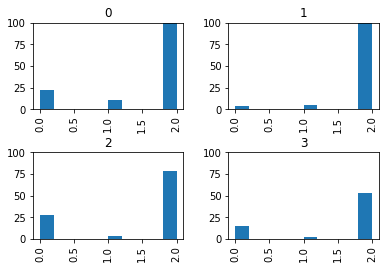

In [31]:
ax = bathsoap_df.hist(by='cluster',column = 'SEX')
ax[0][0].set_ylim((0,100))
ax[0][1].set_ylim((0,100))
ax[1][0].set_ylim((0,100))
ax[1][1].set_ylim((0,100))
plt.show()

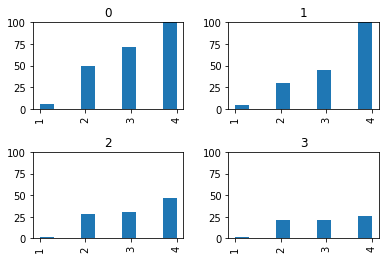

In [32]:
ax = bathsoap_df.hist(by='cluster',column = 'AGE')
ax[0][0].set_ylim((0,100))
ax[0][1].set_ylim((0,100))
ax[1][0].set_ylim((0,100))
ax[1][1].set_ylim((0,100))
plt.show()

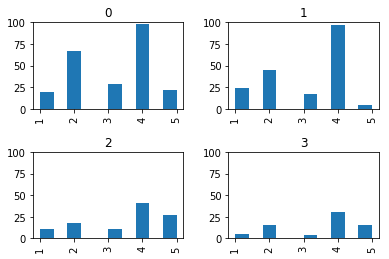

In [33]:
ax = bathsoap_df.hist(by='cluster',column = 'CHILD')
ax[0][0].set_ylim((0,100))
ax[0][1].set_ylim((0,100))
ax[1][0].set_ylim((0,100))
ax[1][1].set_ylim((0,100))
plt.show()

We can get some information about gender, children number etc to see advertisements should be targeted to what population. Combine with the 4 clusters about brand loyalty, price off value soap, exchange offers etc to see what customers should be targeted.

# 3. Develop a model that classifies the data into these segments.

We can use both purchase behavior and basis of purchase variables as input, cluster segment as depedent variable to create a classification decision tree model to predict future cluster segment for a new customer.

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score#, confusion_matrix
from sklearn.model_selection import cross_val_score

In [39]:
defaultRpart = {'min_samples_split': 20,
                'max_depth': 30,
                'min_impurity_decrease': 0.01,
               }

train_df = behaviorbasis_df.sample(frac=0.6, random_state=0)
valid_df = behaviorbasis_df.drop(train_df.index)
classTree = DecisionTreeClassifier(random_state=0, max_depth=6)
classTree.fit(train_df, bathsoap_df.loc[train_df.index].cluster)
defaultTree_predTrain = classTree.predict(train_df)
classificationSummary(bathsoap_df.loc[train_df.index].cluster, defaultTree_predTrain,
                      class_names=[str(s) for s in classTree.classes_])
defaultTree_predValid = classTree.predict(valid_df)
classificationSummary(bathsoap_df.loc[valid_df.index].cluster, defaultTree_predValid,
                      class_names=[str(s) for s in classTree.classes_])

Confusion Matrix and Statistics

          Reference
Prediction   0   1   2   3
         0 149   1   4   0
         1  10  98   0   0
         2   1   0  60   0
         3   0   0   0  37
             precision    recall  f1-score   support

          0     0.9313    0.9675    0.9490       154
          1     0.9899    0.9074    0.9469       108
          2     0.9375    0.9836    0.9600        61
          3     1.0000    1.0000    1.0000        37

avg / total     0.9570    0.9556    0.9555       360

              Accuracy : 0.956
                95% CI : missing
   No Information Rate : missing
   P-Value [Acc > NIR] : missing

                 Kappa : 0.935
Mcnemar's Test P-Value : missing

           Sensitivity : 0.993
           Specificity : 0.907
        Pos Pred Value : 0.937
        Neg Pred Value : 0.990
            Prevalence : 0.581
        Detection Rate : missing
  Detection Prevalence : missing
     Balanced Accuracy : 0.950
Confusion Matrix and Statistics

          

From the above decision tree both train and validation accuracy, decision tree is a good model for decide new customer cluster segment etc. 